In [4]:
import itertools
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import random
seaborn_palettes = list(sns.palettes.SEABORN_PALETTES.keys())

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [5]:
# Reading into a csv file
df=pd.read_csv(r'Documents/Treasure/pythonic/Data Sets/Mobiles_Dataset.csv')

In [6]:
df.head(2)

,Product Name,Actual price,Discount price,Stars,Rating,Reviews,RAM (GB),Storage (GB),Display Size (inch),Camera,Description,Link
0,"Apple iPhone 15 (Green, 128 GB)","₹79,600","₹65,999",4.6,"44,793 Ratings","2,402 Reviews",NIL,128,6.1,48MP + 12MP,128 GB ROM15.49 cm (6.1 inch) Super Retina XDR...,https://www.flipkart.com/apple-iphone-15-green...
1,"Apple iPhone 15 (Blue, 128 GB)","₹79,600","₹65,999",4.6,"44,793 Ratings","2,402 Reviews",NIL,128,6.1,48MP + 12MP,128 GB ROM15.49 cm (6.1 inch) Super Retina XDR...,https://www.flipkart.com/apple-iphone-15-blue-...


In [7]:
df.shape

(984, 12)

- The dataset has 984 rows and 12 columns

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Product Name         984 non-null    object 
 1   Actual price         984 non-null    object 
 2   Discount price       984 non-null    object 
 3   Stars                984 non-null    float64
 4   Rating               984 non-null    object 
 5   Reviews              984 non-null    object 
 6   RAM (GB)             984 non-null    object 
 7   Storage (GB)         984 non-null    object 
 8   Display Size (inch)  984 non-null    float64
 9   Camera               908 non-null    object 
 10  Description          984 non-null    object 
 11  Link                 984 non-null    object 
dtypes: float64(2), object(10)
memory usage: 92.4+ KB


## Data types of each columns are:


In [9]:
df.dtypes

Product Name            object
Actual price            object
Discount price          object
Stars                  float64
Rating                  object
Reviews                 object
RAM (GB)                object
Storage (GB)            object
Display Size (inch)    float64
Camera                  object
Description             object
Link                    object
dtype: object

# Issues Identified and Data Cleaning

## Issues Identified in the Dataset:
- Data types in some colums ought to be float, but are object, hence adjustment:
  1. Actual price
  2. Discount price
  3. Rating
  4. Reviews
  5. RAM (GB)
  6. storage (GB)
- Missing data
- Unreal values in the RAM (GB) column
- Alot of missing values (NIL) in the RAM (GB) and Storage (GB) column, will have to extract it's values from the Description column
  
  

In [10]:
df.columns

Index(['Product Name', 'Actual price', 'Discount price', 'Stars', 'Rating',
       'Reviews', 'RAM (GB)', 'Storage (GB)', 'Display Size (inch)', 'Camera',
       'Description', 'Link'],
      dtype='object')

In [11]:
# dropping columns that are irrelevant

df.drop(['Link'], axis=1, inplace=True)

In [12]:
# Checking for NIL values in 'Actual price' column
nil_count=(df['Actual price']=='NIL').sum()
nil_count

54

In [13]:
# Checking for NIL values in 'Discount price column
nil_count=(df['Discount price']== 'NIL').sum()
nil_count

0

In [14]:
# Removing the NIL Values in 'Actual price' column
# make the missing value for actual price == discount price

df.loc[df['Actual price']== 'NIL', 'Actual price']= df['Discount price']

# Cleaning
Define a function to adjust a DataFrame column in an object state to a float.

In [15]:
def convert_columns(df, column_name):
  """
  Adjust a DataFrame column in an object state to a float.

  Parameters:
  - df: The DataFrame containing the column.
  - column_name: The name of the column to be adjusted.

  Returns:
  - DataFrame: The adjusted DataFrame.

  Raises:
  ValueError: If any of the parameters is empty.
  """

  # convert the column to string
  df[column_name] = df[column_name].astype(str)

  # remove non-numeric characters, and replace empty spaces with Nan, and convert to float
  df[column_name] = df[column_name].str.replace("[₹, Ratings, Reviews]", "", regex=True).replace('', np.nan).astype(float)

  return df

Adjust Actual price, Discount price, Rating, Reviews columns from object state to float.

In [16]:
columns_to_convert = ['Actual price', 'Discount price', 'Rating', 'Reviews']

for _ in columns_to_convert:
    df = convert_columns(df, _)

Define a function to extract vitals (Ram and Storage) from Description using regex.

In [17]:
def extract_ram_storage(description):
  """
  Extract RAM and storage information from a given description.

  Parameters:
  description (str): A string containing RAM and storage details.

Returns:
    tuple: A tuple containing the RAM in GB/MB and storage in GB/MB.
          None if not found.
  """

  def extract_value(pattern, description):
    """Helper function to extract a numeric value based on a regex pattern."""
    match = re.search(pattern, description)
    return int(match.group(1)) if match else None

  # Define regex patterns for RAM and Storage
  ram_pattern = r'(\d+)\s*(GB|MB)\s*RAM'
  storage_pattern = r'(\d+)\s*(GB|MB)\s*(?:Storage|Internal|ROM)'

  # Extract RAM and Storage
  ram = extract_value(ram_pattern, description)
  storage = extract_value(storage_pattern, description)

  return ram, storage

Apply the extract_ram_storage function to extract RAM and Storage, and create new columns.

In [18]:
df["RAM (GB)"], df["Storage (GB)"] = zip(*df["Description"].apply(extract_ram_storage))

# drop unreal values in the RAM (GB) column
df = df[df["RAM (GB)"] != 46875.0]
df = df[df["RAM (GB)"] != 500.0]

Rename Columns

In [19]:
df.rename(columns={"Actual price": "Actual_price(₹)",
                   "Discount price": "Discount_price(₹)",
                   "Display Size (inch)": "Display_size(inch)"
                   },
          inplace=True)

Add Discount Amount column.

In [20]:
df["Discount_amount(%)"] = (100 - df["Discount_price(₹)"] / df["Actual_price(₹)"] * 100)

Define function to extract the brand names from the product name.

In [21]:
df["Brand"] = df["Product Name"].str.split().str[0]
brand_names = df["Brand"].unique()

def extract_brand(product_name):
  """
  Extract the brand from the product name.

  Parameters:
  product_name (str): The name of the product from which to extract the brand.
  brand_names (list | str): A list of known brand names, or longtext to check against.

  Returns:
  str: The matched brand name if found; otherwise, 'Unknown'.
  """

  # Ensure the product name is a string
  if not isinstance(product_name, str):
    raise ValueError("The product_name must be a string.")

  product_name_lower = product_name.lower()

  for brand in brand_names:
    if product_name_lower.startswith(brand.lower()):
      return brand
  return "Unknown"  # default value if no brand matches

Apply the extract_brand function to extract brand names.

In [22]:
df["Brand"] = df["Product Name"].apply(extract_brand)

Reindexing the colums.

In [23]:
new_order = ["Product Name", "Actual_price(₹)", "Discount_price(₹)", "Discount_amount(%)",
             "Stars", "Rating", "Reviews",
             "RAM (GB)", "Storage (GB)",
             "Display_size(inch)", "Camera", "Description",
             "Brand"]

df = df.reindex(columns = new_order)

Define function to split, clean and to convert the camera column.

In [24]:
def split_and_convert_camera(camera):
  """
  Split, clean and to convert the camera column.

  Parameters
  - camera: the camera string

  Returns
  - main_camera: the main camera value
  - second_camera: the second camera value
  Otherwise return NaN for both

  Raises
  - ValueError: if the input is not a string
  """

  if isinstance(camera, str):  # ensure the entry is a string
    # replace separators with a consistent one, such as '+'
    camera = camera.replace(' | ', ' + ').replace('MP', '').strip()

    # split multiple cameras
    cameras = camera.split(' + ')

    # convert to integers and assign to main and second camera
    cameras = [int(cam) for cam in cameras if cam.isdigit()]  # Convert to integers

    # sort cameras for consistency (largest to smallest)
    cameras.sort(reverse=True)

    # assign to main and second camera
    main_camera = float(cameras[0]) if len(cameras) > 0 else np.nan
    second_camera = float(cameras[1]) if len(cameras) > 1 else np.nan

    return main_camera, second_camera
  return np.nan, np.nan  # If it's not a string, return NaN for both

Apply the split_and_convert_camera function to split Camera into Main Camera(MP) and Second Camera(MP).

In [25]:
df["Main Camera(MP)"], df["Second Camera(MP)"] = zip(*df["Camera"].apply(split_and_convert_camera))

In [26]:
df.head(2)

,Product Name,Actual_price(₹),Discount_price(₹),Discount_amount(%),Stars,Rating,Reviews,RAM (GB),Storage (GB),Display_size(inch),Camera,Description,Brand,Main Camera(MP),Second Camera(MP)
0,"Apple iPhone 15 (Green, 128 GB)",79600.0,65999.0,17.086683,4.6,44793.0,2402.0,NaN,128.0,6.1,48MP + 12MP,128 GB ROM15.49 cm (6.1 inch) Super Retina XDR...,Apple,48.0,12.0
1,"Apple iPhone 15 (Blue, 128 GB)",79600.0,65999.0,17.086683,4.6,44793.0,2402.0,NaN,128.0,6.1,48MP + 12MP,128 GB ROM15.49 cm (6.1 inch) Super Retina XDR...,Apple,48.0,12.0


In [27]:
df["RAM (GB)"].value_counts()

RAM (GB)
8.0     384
4.0     200
12.0    125
6.0     116
32.0     61
3.0      13
16.0     12
2.0       6
64.0      4
24.0      2
48.0      2
20.0      1
Name: count, dtype: int64

In [28]:
df.isnull().sum()

Product Name            0
Actual_price(₹)         4
Discount_price(₹)       4
Discount_amount(%)      4
Stars                   0
Rating                  0
Reviews                 0
RAM (GB)               55
Storage (GB)            4
Display_size(inch)      0
Camera                 76
Description             0
Brand                   0
Main Camera(MP)        76
Second Camera(MP)     371
dtype: int64

Handle missing values in the dataset.

Replace missing values in the specified columns with its median because they are not normally distributed.

Define function to replace missing values in a specified column of a DataFrame with the median value of that column.

In [29]:
def replace_missing_values(df, column_name):
  """
  Replace missing values in a specified column of a DataFrame with the median value of that column.

  Parameters:
  - df (pd.DataFrame): The DataFrame in which to replace missing values.
  - column_name (str): The name of the column where missing values will be replaced.

  Returns:
  pd.DataFrame: The DataFrame with missing values replaced.

  Raises:
  ValueError: If the specified column does not exist in the DataFrame or if the DataFrame is empty
  """

  # Check if the DataFrame is empty
  if df.empty:
    raise ValueError("The DataFrame is empty.")

  # Check if the column exists in the DataFrame
  if column_name not in df.columns:
    raise ValueError(f"The column '{column_name}' does not exist in the DataFrame.")

  median_value = df[column_name].median()

  df[column_name] = df[column_name].fillna(median_value)
  return df

Apply replace_missing_values function to the specified colums columns_to_replace.

In [30]:
columns_to_replace = ["Actual_price(₹)", "Discount_price(₹)", "Storage (GB)", "RAM (GB)"]

for columns in columns_to_replace:
    df_new = replace_missing_values(df, columns)

In [31]:
df.head()

,Product Name,Actual_price(₹),Discount_price(₹),Discount_amount(%),Stars,Rating,Reviews,RAM (GB),Storage (GB),Display_size(inch),Camera,Description,Brand,Main Camera(MP),Second Camera(MP)
0,"Apple iPhone 15 (Green, 128 GB)",79600.0,65999.0,17.086683,4.6,44793.0,2402.0,8.0,128.0,6.10,48MP + 12MP,128 GB ROM15.49 cm (6.1 inch) Super Retina XDR...,Apple,48.0,12.0
1,"Apple iPhone 15 (Blue, 128 GB)",79600.0,65999.0,17.086683,4.6,44793.0,2402.0,8.0,128.0,6.10,48MP + 12MP,128 GB ROM15.49 cm (6.1 inch) Super Retina XDR...,Apple,48.0,12.0
2,"Apple iPhone 15 (Black, 128 GB)",79600.0,65999.0,17.086683,4.6,44793.0,2402.0,8.0,128.0,6.10,48MP + 12MP,128 GB ROM15.49 cm (6.1 inch) Super Retina XDR...,Apple,48.0,12.0
3,"OnePlus N20 SE (JADE WAVE, 128 GB)",19999.0,11489.0,42.552128,4.0,1005.0,41.0,4.0,128.0,6.56,50MP,4 GB RAM | 128 GB ROM16.66 cm (6.56 inch) Disp...,OnePlus,50.0,NaN
4,"OnePlus N20 SE (BLUE OASIS, 64 GB)",16999.0,12999.0,23.530796,4.0,1005.0,41.0,4.0,64.0,6.56,50MP,4 GB RAM | 64 GB ROM16.66 cm (6.56 inch) Displ...,OnePlus,50.0,NaN


# EDA

In [32]:
df.describe()

,Actual_price(₹),Discount_price(₹),Discount_amount(%),Stars,Rating,Reviews,RAM (GB),Storage (GB),Display_size(inch),Main Camera(MP),Second Camera(MP)
count,981.000000,981.000000,977.000000,981.000000,981.000000,981.000000,981.000000,981.000000,981.000000,905.000000,610.000000
mean,26535.335372,21553.844037,20.661647,4.255861,23200.480122,1463.979613,9.299694,164.007136,6.053441,41.794475,8.077049
std,24053.389582,20814.554925,10.129065,0.199384,54415.433025,3021.536432,7.616570,108.698239,1.572554,27.863006,11.007490
min,1199.000000,809.000000,0.000000,3.400000,4.000000,0.000000,2.000000,0.000000,0.660000,0.000000,0.000000
25%,11999.000000,8999.000000,14.286395,4.200000,670.000000,37.000000,6.000000,128.000000,6.500000,13.000000,2.000000
50%,19999.000000,15999.000000,20.001000,4.300000,5161.000000,342.000000,8.000000,128.000000,6.670000,50.000000,5.000000
75%,32999.000000,27259.000000,27.170448,4.400000,17216.000000,1414.000000,8.000000,256.000000,6.720000,50.000000,8.000000
max,176999.000000,176999.000000,55.021162,5.000000,429459.000000,23258.000000,64.000000,512.000000,7.820000,200.000000,50.000000


# Brand Analysis
# Question:
## Which brands are most common in the dataset, and how do their average price compare?

Performing Brand Analysis

In [33]:
brand_count = df["Brand"].value_counts()
print("Brand Frequency Analysis")

ddf = pd.DataFrame(brand_count)
ddf

Brand Frequency Analysis


,count
Brand,
realme,124
REDMI,104
SAMSUNG,102
vivo,91
OPPO,72
Motorola,64
POCO,62
Infinix,51
itel,48


Calculate average price for each brand.

In [34]:
average_price_per_brand = df.groupby('Brand')['Actual_price(₹)'].mean().sort_values(ascending=False)
print("\nAverage Price per brand:")

ddf = pd.DataFrame(average_price_per_brand)
ddf


Average Price per brand:


,Actual_price(₹)
Brand,
Apple,78084.615385
Xiaomi,63749.000000
Google,60599.000000
SAMSUNG,47109.980392
OnePlus,43235.842105
Honor,39499.000000
Nothing,33199.000000
vivo,28888.813187
OPPO,25304.555556


In [35]:
sns.set_theme(style="dark")

Plotting Brand Frequency

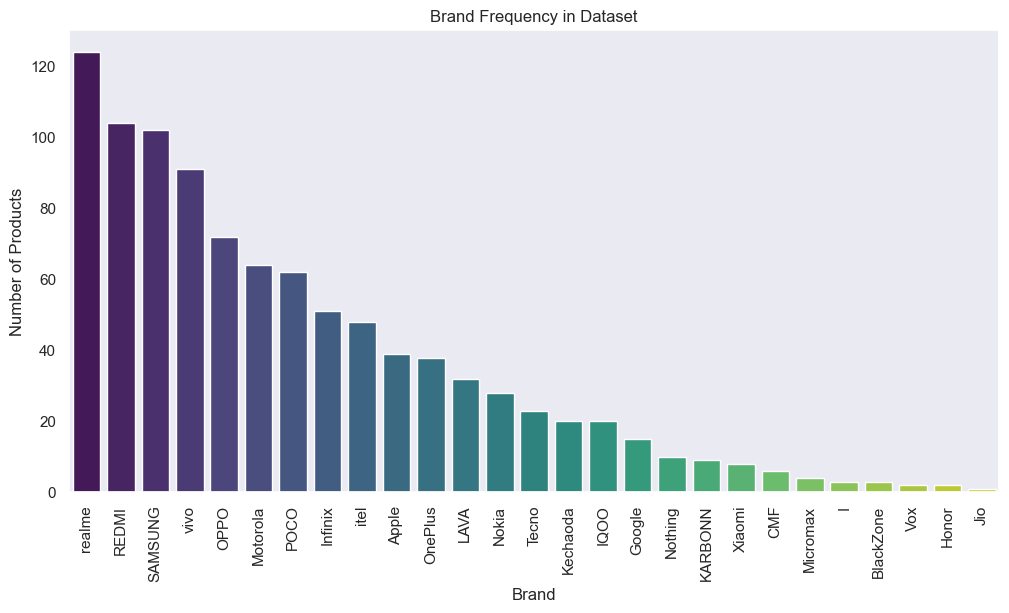

In [37]:
plt.figure(figsize=(12, 6))
sns.barplot(x=brand_count.index, hue=brand_count.index, y=brand_count.values, palette="viridis", legend=False)
plt.title("Brand Frequency in Dataset")
plt.xlabel("Brand")
plt.ylabel("Number of Products")
plt.xticks(rotation=90)
plt.show()

Plotting Average prices by Brand

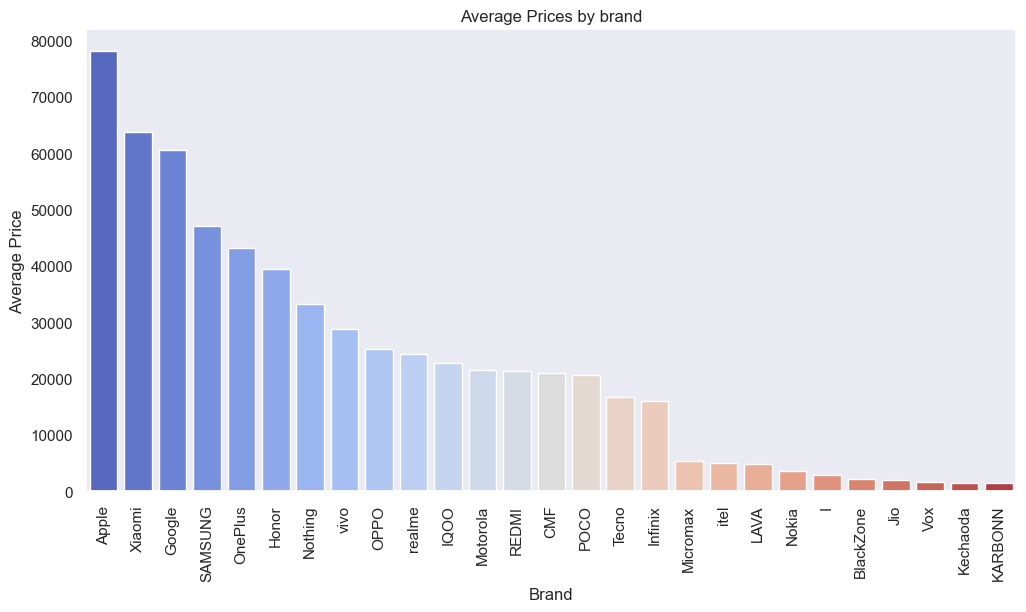

In [38]:
plt.figure(figsize=(12, 6))
sns.barplot(x=average_price_per_brand.index, hue=average_price_per_brand.index, y=average_price_per_brand.values, palette="coolwarm", legend=False)
plt.title("Average Prices by brand")
plt.xlabel("Brand")
plt.ylabel("Average Price")
plt.xticks(rotation=90)
plt.show()

Get distribution of all columns

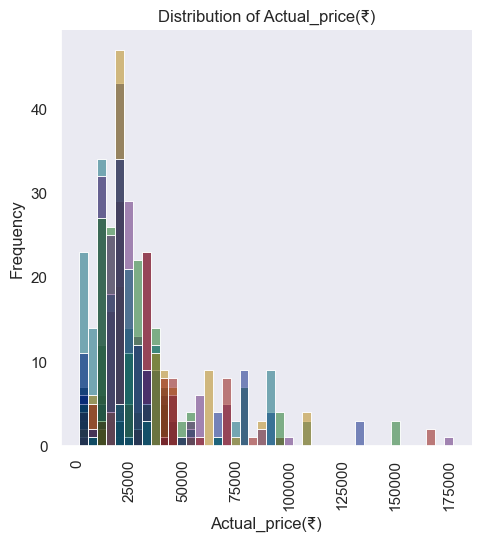

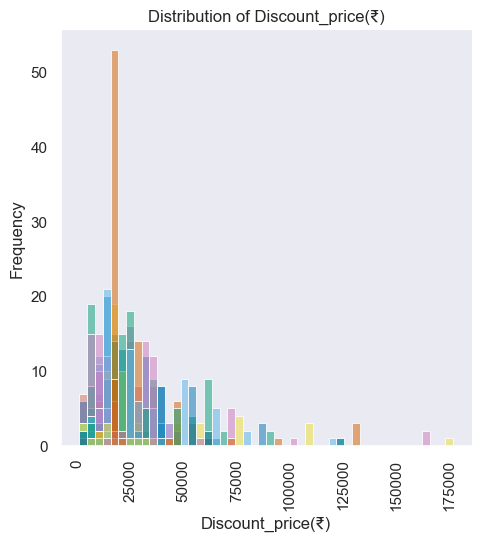

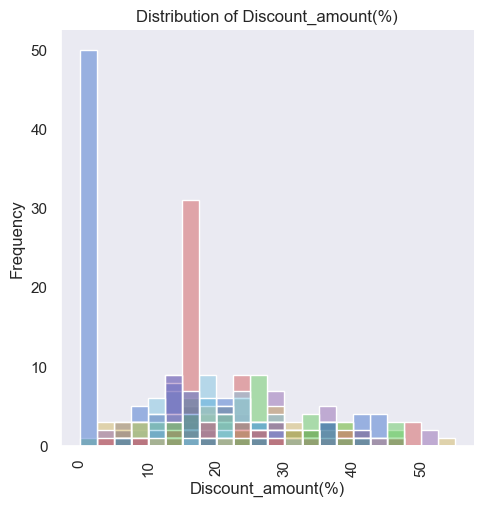

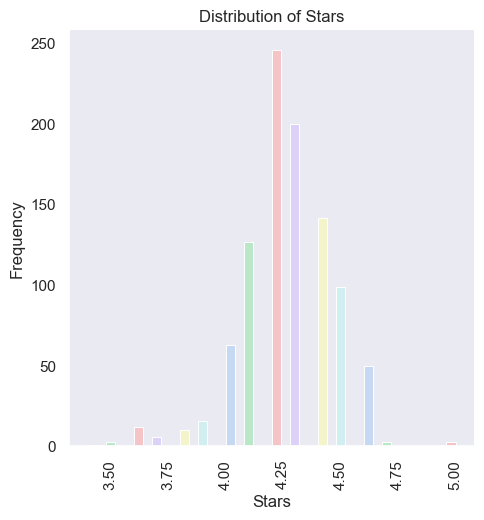

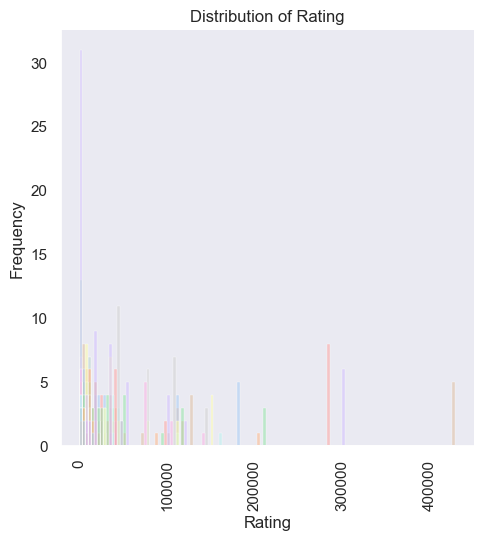

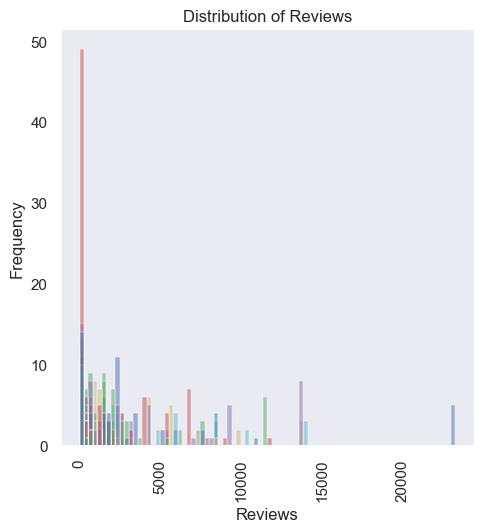

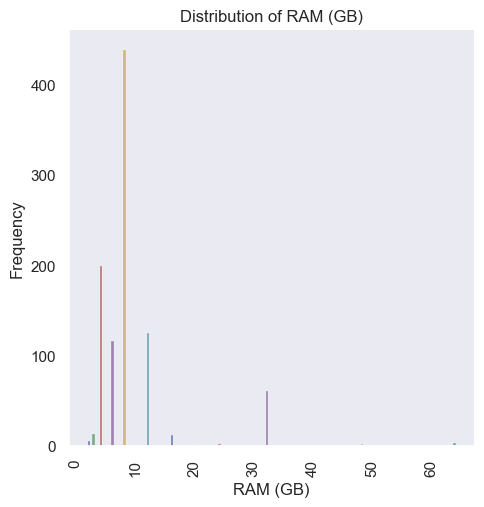

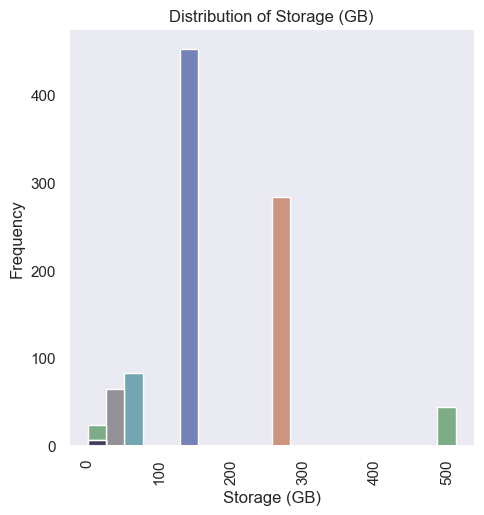

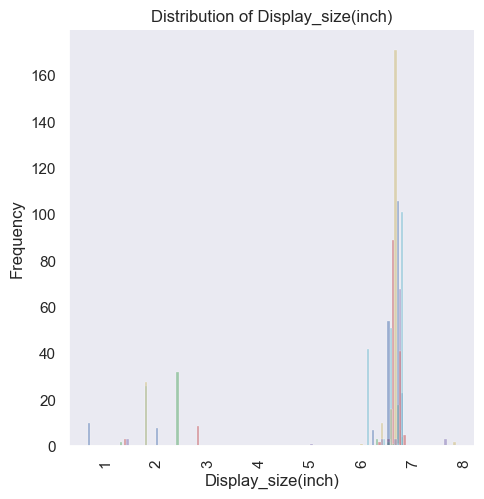

In [39]:
columns = df.columns.tolist()

for i in range(1, 10):
  column_name = columns[i]
  selected_palette = random.choice(seaborn_palettes)
  sns.displot(x=column_name, hue=column_name, data=df, palette=selected_palette, legend=False)
  plt.title(f"Distribution of {column_name}")
  plt.xlabel(column_name)
  plt.ylabel("Frequency")
  plt.xticks(rotation=90)
  plt.show()

In [40]:
df.columns

Index(['Product Name', 'Actual_price(₹)', 'Discount_price(₹)',
       'Discount_amount(%)', 'Stars', 'Rating', 'Reviews', 'RAM (GB)',
       'Storage (GB)', 'Display_size(inch)', 'Camera', 'Description', 'Brand',
       'Main Camera(MP)', 'Second Camera(MP)'],
      dtype='object')

In [41]:
# separating numerical columns from categorical columns
numerical_col=[col for col in df.columns if df[col].dtype in ['int64', 'float64']]
categorical_col=[col for col in df.columns if df[col].dtype in ['object']]

In [42]:
numerical_col

['Actual_price(₹)',
 'Discount_price(₹)',
 'Discount_amount(%)',
 'Stars',
 'Rating',
 'Reviews',
 'RAM (GB)',
 'Storage (GB)',
 'Display_size(inch)',
 'Main Camera(MP)',
 'Second Camera(MP)']

In [43]:
categorical_col

['Product Name', 'Camera', 'Description', 'Brand']

# Correlation Analysis

# Question:
## Does any relationship exists between the Actual_price, Ram, Storage, Main Camera, Second Camera in the data set?

In [44]:
# Correlation matrix 
correlation_matrix=df[['Actual_price(₹)', 'RAM (GB)', 'Storage (GB)', 'Main Camera(MP)', 'Second Camera(MP)']].corr()
print("Correlation Matrix:")

ddf=pd.DataFrame(correlation_matrix)
ddf

Correlation Matrix:


,Actual_price(₹),RAM (GB),Storage (GB),Main Camera(MP),Second Camera(MP)
Actual_price(₹),1.000000,-0.072729,0.550111,0.273193,0.436427
RAM (GB),-0.072729,1.000000,-0.035261,-0.263012,-0.025374
Storage (GB),0.550111,-0.035261,1.000000,0.254595,0.273833
Main Camera(MP),0.273193,-0.263012,0.254595,1.000000,0.224276
Second Camera(MP),0.436427,-0.025374,0.273833,0.224276,1.000000


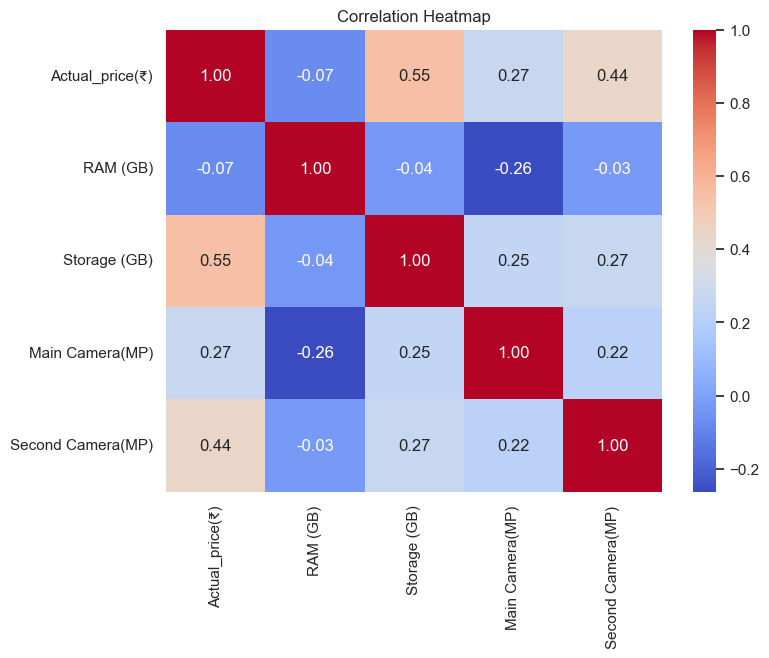

In [45]:
# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

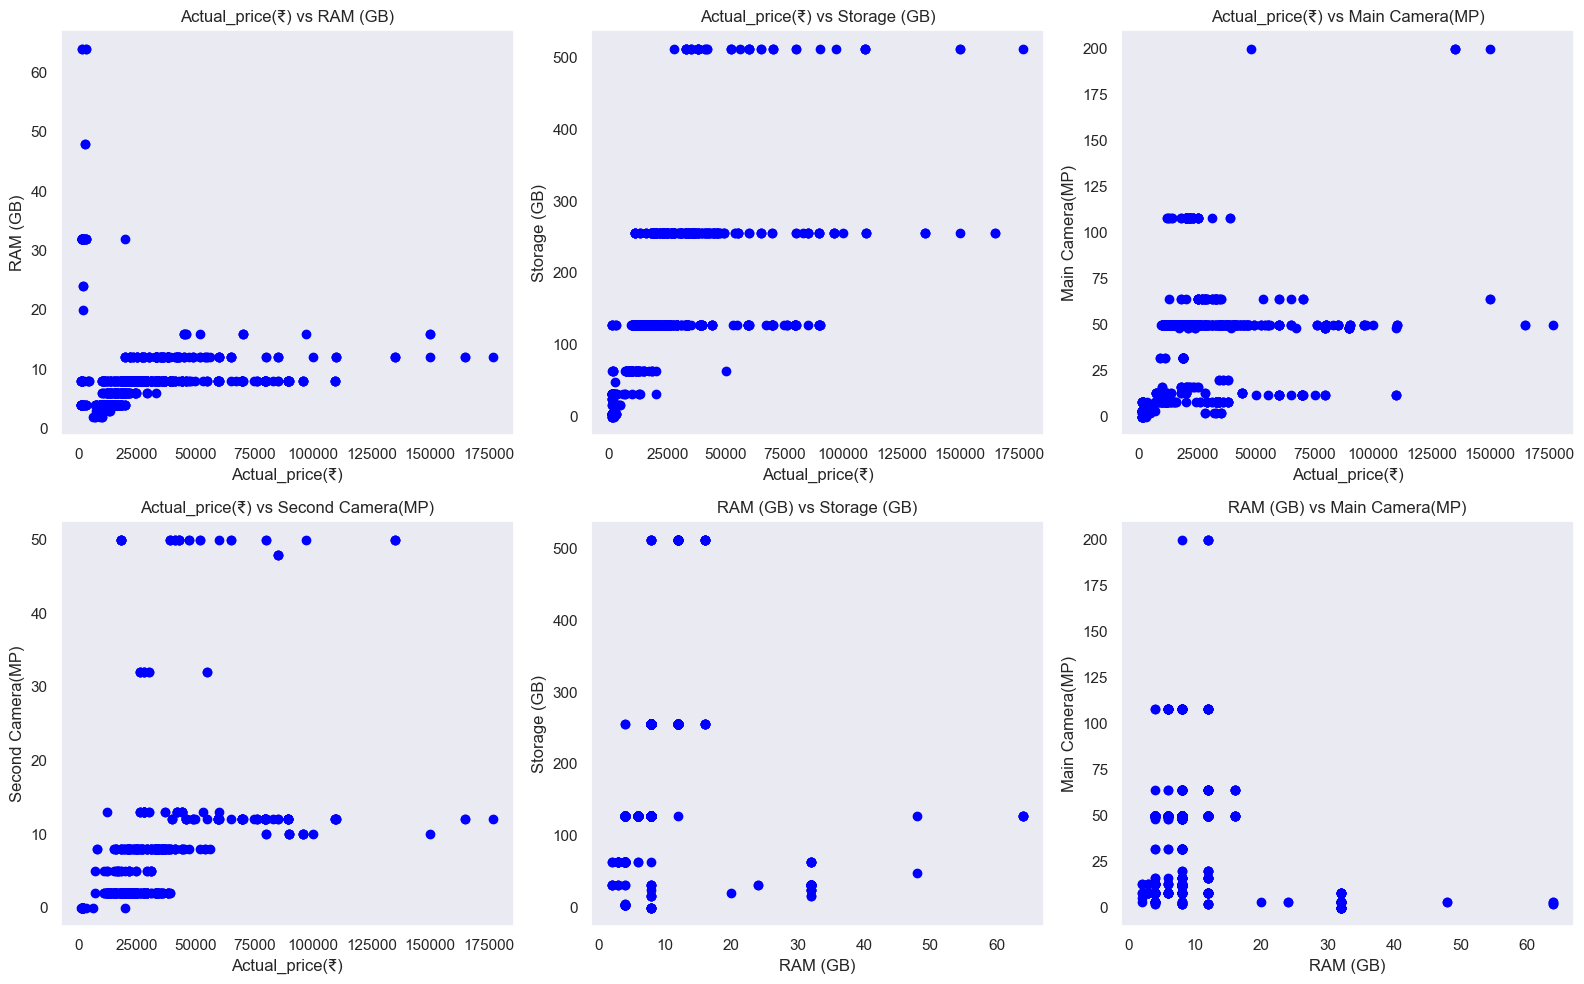

In [46]:
# scatterplot

columns=['Actual_price(₹)', 'RAM (GB)', 'Storage (GB)', 'Main Camera(MP)', 'Second Camera(MP)']
selected_data=df[columns]

fig, axs=plt.subplots(2, 3, figsize=(16, 10))

# Generate all unique pairs of columns for scatter plot
pairs=list(itertools.combinations(selected_data, 2))
pairs=pairs[:6]

# looping through each subplot and plot scatterplots for each pair of columns
for i, (col_x, col_y) in enumerate(pairs):
    row = i // 3
    col = i % 3
    axs[row, col].scatter(df[col_x], df[col_y], color='blue')
    axs[row, col].set_title(f'{col_x} vs {col_y}')
    axs[row, col].set_xlabel(col_x)
    axs[row, col].set_ylabel(col_y)

# Adjust layout for better spacing
plt.tight_layout()

# showing plots
plt.show()


# Camera Analysis
# Question
## What is the common camera resolution of mobile phone dataset and how does it affects the price?
Define a function to analyze camera resolution.

In [47]:
def analyze_camera_resolution(df, camera_column):
  """
  Analyze the camera resolution in the dataset.

  Parameters:
  - df (pd.DataFrame): The DataFrame containing the data.
  - camera_column (str): The name of the column representing the camera resolution.

  Returns:
  pd.Series: A Series containing the frequency of each camera resolution.

  Raises:
  ValueError: If the specified column does not exist in the DataFrame or if the DataFrame is empty.
  """

  specified_camera = df[camera_column].value_counts().sort_index()
  print("{} Resolution: ".format(camera_column))
  ddf = pd.DataFrame(specified_camera)
  return ddf

Analyze the main camera resolution.

In [48]:
analyze_camera_resolution(df, "Main Camera(MP)")

Main Camera(MP) Resolution: 


,count
Main Camera(MP),
0.0,14
2.0,14
3.0,53
5.0,1
8.0,96
12.0,26
13.0,34
16.0,19
20.0,6


Analyzing the second camera resolution.

In [49]:
analyze_camera_resolution(df, "Second Camera(MP)")

Second Camera(MP) Resolution: 


,count
Second Camera(MP),
0.0,39
2.0,257
5.0,26
8.0,137
10.0,12
12.0,71
13.0,27
32.0,10
48.0,3


Define a function to calculate the average price for each camera resolution in the dataset.

In [50]:
def calculate_avg_price_by_camera_resolution(df, camera_column, price_column):
  """
  Calculate the average price for each camera resolution in the dataset.

  Parameters:
  - df (pd.DataFrame): The DataFrame containing the data.
  - camera_column (str): The name of the column representing the camera resolution.
  - price_column (str): The name of the column representing the price.

  Returns:
  pd.Series: A Series containing the average price for each camera resolution.

  Raises:
  ValueError: If the specified columns do not exist in the DataFrame or if the DataFrame is empty.
  """

  # Finding the average price based on camera resolution for main camera
  avg_price_by_camera_col = df.groupby(camera_column)[price_column].mean().sort_values(ascending=True)
  print("\nAverage Price by {} Resolution".format(camera_column))
  ddf = pd.DataFrame(avg_price_by_camera_col)
  return ddf


Finding the average price based on camera resolution for main camera.

In [51]:
calculate_avg_price_by_camera_resolution(df, "Main Camera(MP)", "Actual_price(₹)")


Average Price by Main Camera(MP) Resolution


,Actual_price(₹)
Main Camera(MP),
0.0,1655.214286
3.0,2090.037736
5.0,5999.000000
8.0,17958.375000
32.0,17970.428571
13.0,17999.000000
2.0,19665.571429
16.0,19946.368421
108.0,21478.166667


Finding the average price based on camera resolution for second camera.

In [52]:
calculate_avg_price_by_camera_resolution(df, "Second Camera(MP)", "Actual_price(₹)")


Average Price by Second Camera(MP) Resolution


,Actual_price(₹)
Second Camera(MP),
0.0,2181.666667
5.0,20374.192308
2.0,21976.575875
8.0,30228.927007
32.0,33199.000000
13.0,35147.148148
50.0,55426.285714
12.0,77398.140845
48.0,84993.000000


Plotting the distrbution and their impact on price.

Define a function to plot the distribution of camera resolution and its impact on price.

In [53]:
def plot_camera_resolution_distribution(df, camera_column, position):
  """
  Plot the distribution of camera resolution and its impact on price.

  Parameters:
  - df (pd.DataFrame): The DataFrame containing the data.
  - camera_column (str): The name of the column representing the camera resolution.
  - position (tuple): The position of the subplot in the figure.

  Returns:
  None

  Raises:
  ValueError: If the specified columns do not exist in the DataFrame or if the DataFrame is empty.
  """

  plt.figure(figsize=(12, 6))

  specified_camera = df[camera_column].value_counts().sort_index()

  plt.subplot(*position)
  sns.barplot(x=specified_camera.index,
              hue=specified_camera.index,
              y=specified_camera.values,
              palette=random.choice(seaborn_palettes),
              legend=False)
  plt.title("{} Resolution Distribution".format(camera_column))
  plt.xlabel("{}".format(camera_column))
  plt.ylabel("Count")
  plt.xticks(rotation=90)

  plt.tight_layout()
  plt.show()

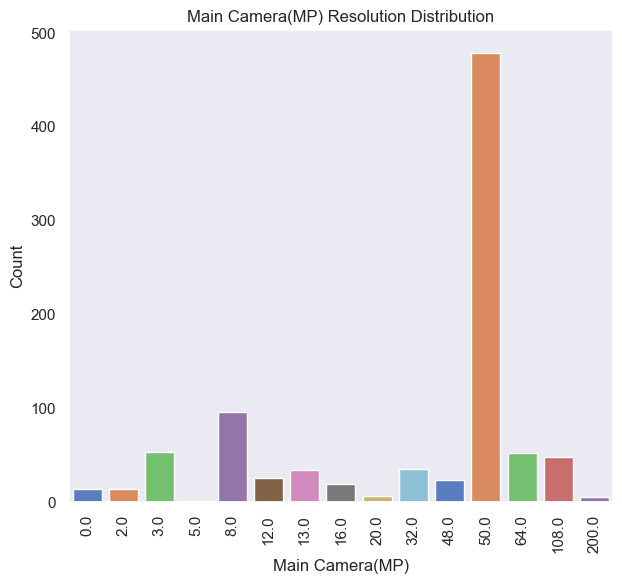

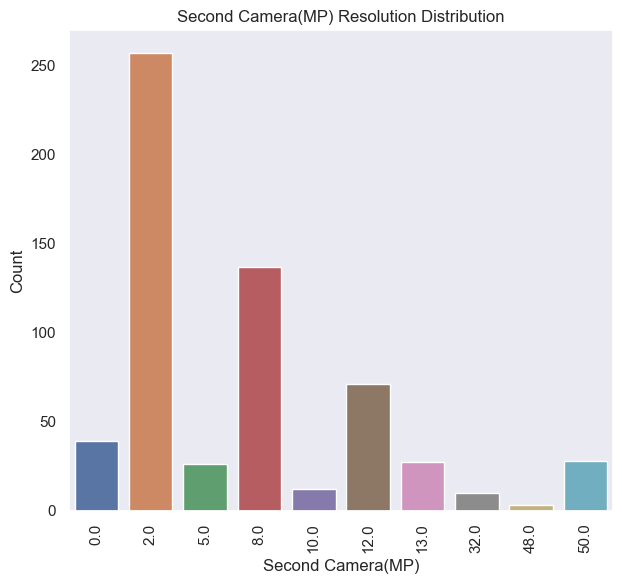

In [54]:
plot_camera_resolution_distribution(df, "Main Camera(MP)", (1, 2, 1))

plot_camera_resolution_distribution(df, "Second Camera(MP)", (1, 2, 2))

Define a function to plot the average price by camera resolution

In [55]:
def plot_avg_price_by_camera_resolution(df, camera_column, price_column, position):
  """
  Plot the average price by camera resolution.

  Parameters:
  - df (pd.DataFrame): The DataFrame containing the data.
  - camera_column (str): The name of the column representing the camera
  resolution.
  - price_column (str): The name of the column representing the price.

  Returns:
  None

  Raises:
  ValueError: If the specified columns do not exist in the DataFrame or if the DataFrame is empty.
  """

  avg_price_by_specified_cam = df.groupby(camera_column)[price_column].mean().sort_values(ascending=True)

  plt.figure(figsize=(12, 6))

  plt.subplot(*position)
  sns.lineplot(x=avg_price_by_specified_cam.index, y=avg_price_by_specified_cam.values, marker='o', color='b')
  plt.title("Average Price by {} Resolution".format(camera_column))
  plt.xlabel("{}".format(camera_column))
  plt.ylabel("Average Price")

  plt.tight_layout()
  plt.show()

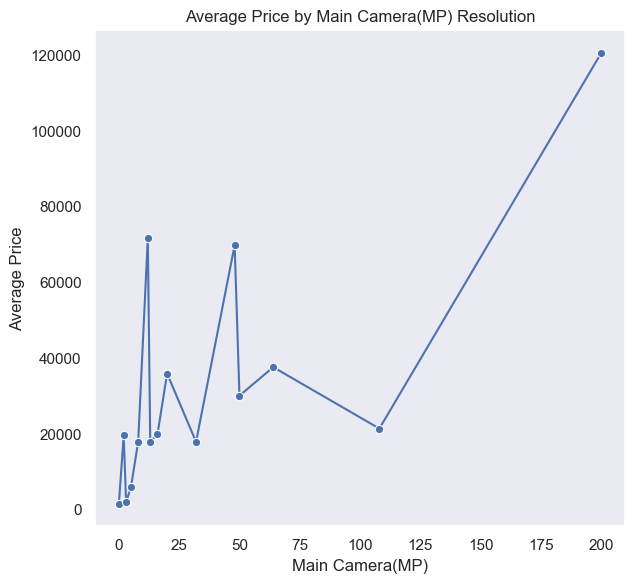

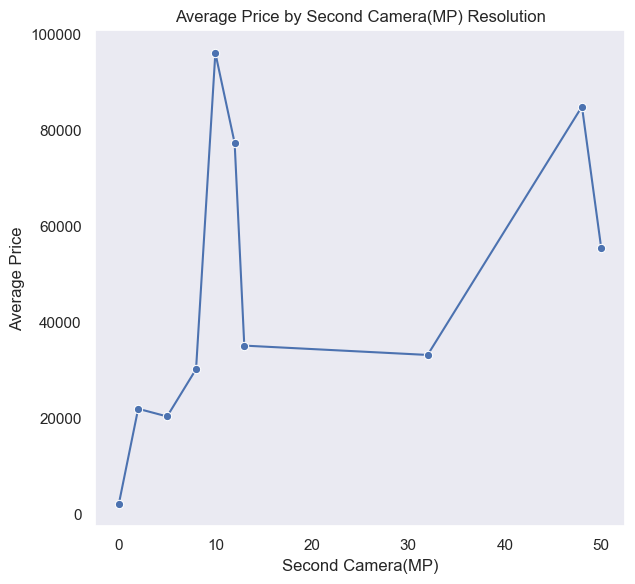

In [56]:
plot_avg_price_by_camera_resolution(df, "Main Camera(MP)", "Actual_price(₹)", (1, 2, 1))

plot_avg_price_by_camera_resolution(df, "Second Camera(MP)", "Actual_price(₹)", (1, 2, 2))

# Key Findings and Insights
## Brand Analysis: 
### Most Common Brand in the Dataset:
From the Brand Frequency Analysis, we can see that Realme is the most common brand in the dataset, followed by REDMI and SAMSUNG.
### Average Price Per Brand:
- Premium Brands: Apple, Xiaomi, Google, and Samsung lead with higher price points
- Mid-range Brands: Brands like Realme, Vivo, and OPPO dominate the mid-range segment with a large number of devices.
- Budget Brands: Brands such as Micromax, itel, and LAVA clearly serve the budget-conscious market.

## Correlation Analysis:
- Storage seems to be the most important factor influencing the Price in the dataset.
- RAM does not have a stromg positive correlation with price, which may be because more affordable models also feature high RAM configuration.
- Camera specifications, especially the Second Camera, moderately impact the Price.

## Common Camera Resolution:
From the analysis of the camera resolution in the datastet, 
#### Main Camera Resolution:
- The most common main camera resolution is 50 MP, with 479 instances.
#### Second Camera Resolution:
- The most common second camera resolution is 2 MP, with 257 instances.
### Average Price Based on Camera Resolution:
The line plots and value counts both show that higher camera resolutions for both the main and second cameras are generally associated with higher average prices. However, there are fluctuations in the mid-range resolutions (e.g., 8 MP to 64 MP) where prices rise and fall unpredictably. The highest resolutions (e.g., 200 MP for the main camera and 50 MP for the second camera) have the highest average prices. Despite these fluctuations, the overall trend indicates that as camera resolution increases, so does the price




